In [1]:
#Libraries import
import pandas as pd
from mordred import Calculator, descriptors
import mordred
import numpy as np
from rdkit import Chem


from sklearn import linear_model

from sklearn.metrics import r2_score

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [2]:
def prepare_data(file):
    
    df = pd.read_excel(file)
    
    try:
        mol_objs = [Chem.MolFromSmiles(smi) for smi in df['SMILES']]
    except:
        mol_objs = [Chem.MolFromSmiles(smi) for smi in df['new_SMILES']]
    
    calculate_descriptors = True
    
    if calculate_descriptors:
        calc = Calculator(descriptors, ignore_3D=True)
        molecular_descriptors = calc.pandas(mol_objs)
        molecular_descriptors = molecular_descriptors.applymap(is_morder_missing)
        molecular_descriptors = molecular_descriptors[sorted(molecular_descriptors.columns)]
    else:
        pass
    print(molecular_descriptors.shape)
    
    simple_preprocessing = True
    if simple_preprocessing:
        molecular_descriptors_cleaned = molecular_descriptors.dropna(axis=1, how='any')
        molecular_descriptors_cleaned
    print(molecular_descriptors_cleaned.shape)
    molecular_descriptors_cleaned = molecular_descriptors_cleaned.loc[:, (molecular_descriptors_cleaned != 0).any(axis=0)]
    print(molecular_descriptors_cleaned.shape)
    
    try:
        molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] = df['Aktywność cytoprotekcyjna [%]']
    except:
        pass
    
    #try:
        #print('Target distribution histogram: ')
        #print(df['Aktywność cytoprotekcyjna [%]'].hist())
    #except:
        #pass
    
    return molecular_descriptors_cleaned

In [3]:
def is_morder_missing(x):
    return np.nan if type(x) == mordred.error.Missing or type(x) == mordred.error.Error else x 

In [4]:
def correlation_dataframe(molecular_descriptors_cleaned, correlation_threshold):
    
    correlation_table = pd.DataFrame(data=molecular_descriptors_cleaned.columns.to_list(), columns=["molecular descriptor name"])
    print(correlation_table.head())
    correlation_to_ak_cyt = []
    for mol_desc in correlation_table['molecular descriptor name']:
        x = np.corrcoef(np.array(molecular_descriptors_cleaned[mol_desc]), np.array(molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]']))
        x = x.tolist()[0][1]
        correlation_to_ak_cyt.append(x)
    correlation_table['corr_value'] = correlation_to_ak_cyt
    print(correlation_table.head())
    correlation_table['absolute correlation value'] = [abs(x) for x in correlation_table['corr_value']]
    print(correlation_table[:-1].head())
    
    mol_desc_best_corr = correlation_table[correlation_table['absolute correlation value'] > correlation_threshold]
    
    print(mol_desc_best_corr.head())
    table_with_descriptors_to_be_used = mol_desc_best_corr[:-1]
    print(table_with_descriptors_to_be_used.head())
    
    #print("Correlation to the target histogram: ")
    #print(correlation_table['absolute correlation value'][:-1].hist(bins=100))
    
    return table_with_descriptors_to_be_used
    

In [5]:
def test_data(molecular_descriptors_cleaned):
    
    test123 = molecular_descriptors_cleaned.loc[(molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 90)
                                                | (molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 70)
                                        | (molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 45)
                                       | (molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 10)
                                               | (molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] == 0)]
    
    test_data = test123.iloc[[0, 1, 2, 5, 15]] #It allows to get 5 different points of known activity
    
    return test_data
    

In [6]:
def prepare_model(data, features, test_data):
    
    X = data[features['molecular descriptor name']]
    
    y = data['Aktywność cytoprotekcyjna [%]']
    
    regr = linear_model.LinearRegression()
    
    regr.fit(X, y)
    
    pred = regr.predict(X)
    print("R^2 score: "+ str(r2_score(y, pred)))
    sqrt_r2 = np.sqrt(r2_score(y, pred))
    training_data_r2 = r2_score(y, pred)
    print('Correlation coefficient: '+ str(sqrt_r2))
    print("Test data - unseen during training:")
    pred = regr.predict(test_data[features['molecular descriptor name']])
    print("R^2 score: "+ str(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]'])))
    sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
    print('Correlation coefficient: '+ str(sqrt_r2))
    print(pred)
    print(test_data['Aktywność cytoprotekcyjna [%]']) 
    test_data_r2 = r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]'])

    return regr, training_data_r2, test_data_r2
    

In [7]:
def data_standarization(dataframe):
    
    dataframe_ = dataframe.drop(['Aktywność cytoprotekcyjna [%]'], axis=1)
    
    to_be_returned = (dataframe_ - dataframe_.mean()) / dataframe_.std()
    to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']
    
    return to_be_returned

In [8]:
def prepare_data_and_create_model(molecular_descriptors_df, correlation_threshold, standarization):
    
    if standarization == True:
        
        print("I am doing standarization...")
        
        data_to_be_prepared = molecular_descriptors_df
        
        stand = data_standarization(data_to_be_prepared)
        
        corr = correlation_dataframe(stand, correlation_threshold)
        
        test_ = test_data(stand)
        
        data_to_be_prepared = stand.drop(test_.index.to_list(), axis=0)
        
        model, train_r2, test_r2 = prepare_model(data_to_be_prepared, corr, test_)
        
    elif standarization == False:
        
        print("I am not doing standarization...")
        
        data_to_be_prepared = molecular_descriptors_df
        
        corr = correlation_dataframe(data_to_be_prepared, correlation_threshold)
        
        test_ = test_data(data_to_be_prepared)
        
        data_to_be_prepared = data_to_be_prepared.drop(test_.index.to_list(), axis=0)
        
        model, train_r2, test_r2 = prepare_model(data_to_be_prepared, corr, test_)
    else:
        print("Error...")
    
    return model, train_r2, test_r2, data_to_be_prepared, corr
    

In [9]:
molecular_descriptors_df = prepare_data('../Data/initial_caffeine.xlsx')

100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 26.29it/s]


(58, 1613)
(58, 1388)
(58, 1137)


In [10]:
without_standarization, train_r2, test_r2, hist1, hist2 = prepare_data_and_create_model(molecular_descriptors_df, 0.33, False)

I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8            

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


Target distribution histogram: 
AxesSubplot(0.125,0.11;0.775x0.77)


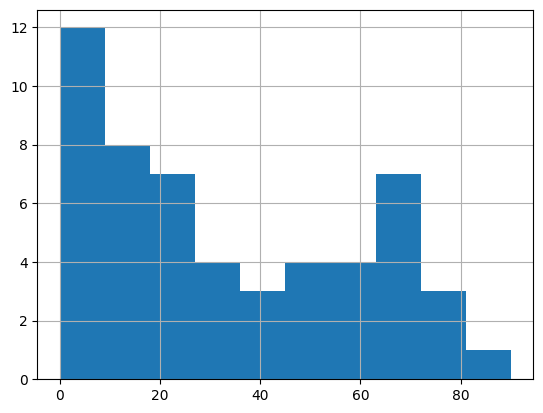

In [11]:
print('Target distribution histogram: ')
print(hist1['Aktywność cytoprotekcyjna [%]'].hist())

In [12]:
print("Number of features (molecular descriptors used): "+ str(len(hist2)))

Number of features (molecular descriptors used): 64


In [13]:
hist2

,molecular descriptor name,corr_value,absolute correlation value
1,AATS0are,0.342320,0.342320
8,AATS0s,0.350131,0.350131
9,AATS0se,0.363989,0.363989
12,AATS1are,0.352396,0.352396
18,AATS1pe,0.338436,0.338436
...,...,...,...
864,SddsN,-0.335349,0.335349
932,SsSH,0.335381,0.335381
936,SssO,0.335389,0.335389
1101,nBondsD,0.369996,0.369996


In [14]:
max(hist2['absolute correlation value'])

0.4825950371651986

In [15]:
with_standarization, train_r2, test_r2, hist1_, hist2_ = prepare_data_and_create_model(molecular_descriptors_df, 0.33, True)

I am doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i


C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


Target distribution histogram: 
AxesSubplot(0.125,0.11;0.775x0.77)


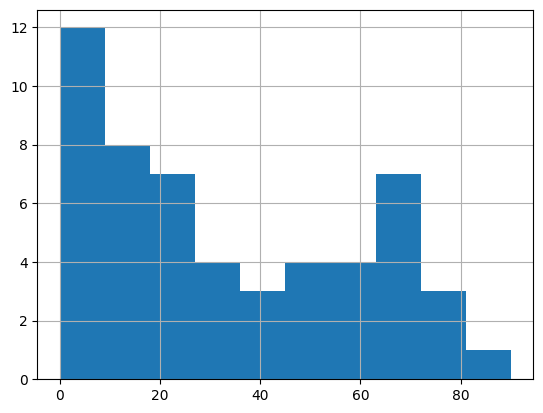

In [16]:
print('Target distribution histogram: ')
print(hist1_['Aktywność cytoprotekcyjna [%]'].hist())

In [17]:
print("Number of features (molecular descriptors used): "+ str(len(hist2)))

Number of features (molecular descriptors used): 64


In [18]:
hist2_

,molecular descriptor name,corr_value,absolute correlation value
1,AATS0are,0.342320,0.342320
8,AATS0s,0.350131,0.350131
9,AATS0se,0.363989,0.363989
12,AATS1are,0.352396,0.352396
18,AATS1pe,0.338436,0.338436
...,...,...,...
864,SddsN,-0.335349,0.335349
932,SsSH,0.335381,0.335381
936,SssO,0.335389,0.335389
1101,nBondsD,0.369996,0.369996


## Search inside correlation space

In [19]:
step = 0.01
initial_step = 0.3
last_step = 0.48
first_list = [x / 100.0 for x in range(int(initial_step*100), int(last_step*100), int(step*100))]
second_list = []
third_list = []
f_list = []
for i in first_list:
    without_standarization, train_r2, test_r2, _, h_ = prepare_data_and_create_model(molecular_descriptors_df, i, False)
    second_list.append(train_r2)
    third_list.append(test_r2)
    f_list.append(len(h_))


I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7            

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = 

In [20]:
df_without_standarization = pd.DataFrame(data=first_list, columns=["Correlation threshold"])

In [21]:
df_without_standarization['Training data R^2 score'] = second_list
df_without_standarization['Test data R^2 score'] = third_list
df_without_standarization['Number of features'] = f_list

In [22]:
df_without_standarization

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features
0,0.30,1.000000,0.019434,87
1,0.31,1.000000,-0.152666,75
2,0.32,1.000000,-2.020326,72
3,0.33,1.000000,-0.196631,64
4,0.34,0.986446,-0.183902,52
5,0.35,0.976187,-0.251792,45
6,0.36,0.906275,-0.083380,38
7,0.37,0.867807,-2.567020,31
8,0.38,0.860818,-3.546321,29
9,0.39,0.762174,-0.198260,23


In [23]:
step = 0.01
initial_step = 0.3
last_step = 0.48
first_list = [x / 100.0 for x in range(int(initial_step*100), int(last_step*100), int(step*100))]
second_list = []
third_list = []
f_list = []
for i in first_list:
    without_standarization, train_r2, test_r2, _, h_ = prepare_data_and_create_model(molecular_descriptors_df, i, True)
    second_list.append(train_r2)
    third_list.append(test_r2)
    f_list.append(len(h_))

I am doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                

C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['A

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.

  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231   

C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231   

C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


R^2 score: 0.5298738422996441
Correlation coefficient: 0.7279243383069727
Test data - unseen during training:
R^2 score: 0.06517454898678976
Correlation coefficient: 0.255293064901477
[135.22924368  14.16448596   8.51200928  56.98636822  53.47779206]
1     45
4     10
5      0
9     90
28    70
Name: Aktywność cytoprotekcyjna [%], dtype: int64
I am doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i


C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


In [24]:
df_with_standarization = pd.DataFrame(data=first_list, columns=["Correlation threshold"])
df_with_standarization['Training data R^2 score'] = second_list
df_with_standarization['Test data R^2 score'] = third_list
df_with_standarization['Number of features'] = f_list

In [25]:
df_with_standarization

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features
0,0.30,1.000000,-0.100270,87
1,0.31,1.000000,-0.057426,75
2,0.32,1.000000,-0.761253,72
3,0.33,1.000000,-0.027760,64
4,0.34,0.986446,-0.183902,52
5,0.35,0.976187,-0.251792,45
6,0.36,0.906275,-0.083380,38
7,0.37,0.867807,-2.567020,31
8,0.38,0.860818,-3.546321,29
9,0.39,0.762174,-0.198260,23


## Plots

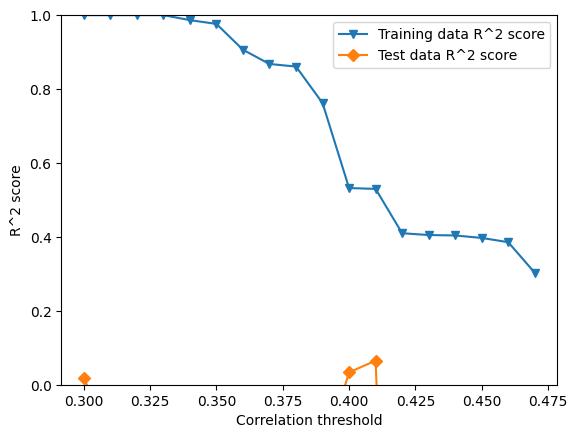

In [26]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Training data R^2 score'], label = "Training data R^2 score", marker='v')
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Test data R^2 score'], label = "Test data R^2 score", marker='D')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('R^2 score')
plt.ylim([0, 1])
plt.show()

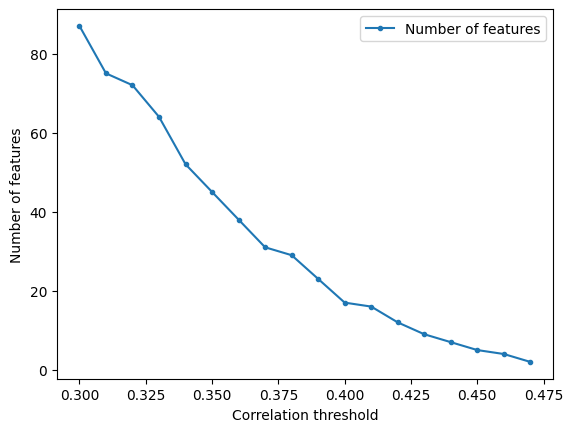

In [27]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Number of features'], label = "Number of features", marker='.')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('Number of features')
plt.show()

# sqrt(R^2)

In [28]:
df_without_standarization['train R value'] = [np.sqrt(x) for x in df_without_standarization['Training data R^2 score']]

In [29]:
df_without_standarization

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features,train R value
0,0.30,1.000000,0.019434,87,1.000000
1,0.31,1.000000,-0.152666,75,1.000000
2,0.32,1.000000,-2.020326,72,1.000000
3,0.33,1.000000,-0.196631,64,1.000000
4,0.34,0.986446,-0.183902,52,0.993200
5,0.35,0.976187,-0.251792,45,0.988022
6,0.36,0.906275,-0.083380,38,0.951985
7,0.37,0.867807,-2.567020,31,0.931561
8,0.38,0.860818,-3.546321,29,0.927803
9,0.39,0.762174,-0.198260,23,0.873026


In [30]:
xcz = []
for element in df_without_standarization['Test data R^2 score']:
    x = np.sqrt(element)
    try:
        if x > 0:
            xcz.append(x)
        else:
            xcz.append(0)
    except:
        pass
    

C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2727130492.py:3: RuntimeWarning: invalid value encountered in sqrt
  x = np.sqrt(element)


In [31]:
xcz

[0.13940491419752032,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.1826254108338999,
 0.25529306490125786,
 0,
 0,
 0,
 0,
 0,
 0]

In [32]:
df_without_standarization['test R value'] = xcz

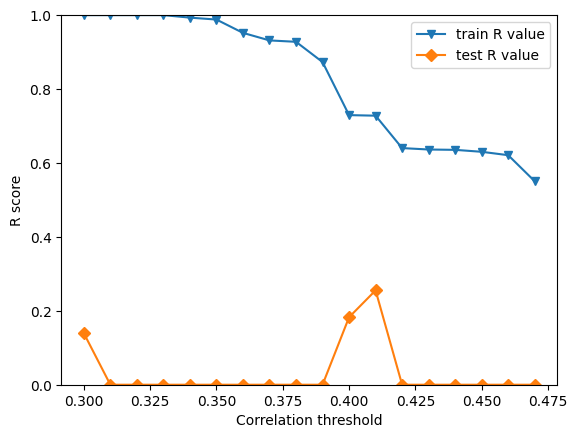

In [33]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['train R value'], label = "train R value", marker='v')
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['test R value'], label = "test R value", marker='D')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('R score')
plt.ylim([0, 1])
plt.show()

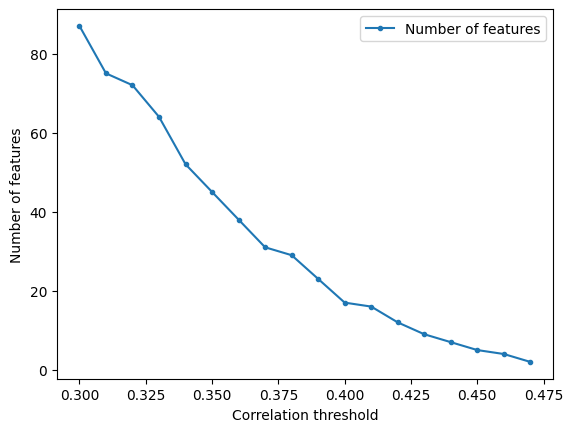

In [34]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Number of features'], label = "Number of features", marker='.')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('Number of features')
plt.show()

## Final model

In [35]:
final_model = prepare_data_and_create_model(molecular_descriptors_df, 0.43, False)

I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145        

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_14748\2714753483.py:19: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, test_data['Aktywność cytoprotekcyjna [%]']))


In [36]:
final_model[0].get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [37]:
final_model[0].intercept_

80.020295174634

In [38]:
final_model[0].coef_

array([ 1.15367450e+01, -2.26834601e+01, -1.86093877e-01,  9.63039386e-01,
       -2.96619688e+02,  2.57911628e+02,  1.04128128e+03, -1.56422909e+03,
       -4.29851097e-01])

## Build equation

In [39]:
final_model[4]

,molecular descriptor name,corr_value,absolute correlation value
100,AATSC1Z,-0.435685,0.435685
145,AATSC4s,-0.431682,0.431682
362,ATSC4s,-0.482595,0.482595
476,EState_VSA1,0.444408,0.444408
530,GATS2Z,-0.472027,0.472027
536,GATS2m,-0.450097,0.450097
646,MATS1Z,-0.464299,0.464299
652,MATS1m,-0.462327,0.462327
839,SMR_VSA1,0.446058,0.446058


In [40]:
names = list(final_model[4]['molecular descriptor name'])
print("The model's equation is: ")
for i in range(len(names)):
    print(str(final_model[0].coef_[i])+str(' * ')+str(names[i]))
    
print(str(final_model[0].intercept_))

The model's equation is: 
11.536745046056343 * AATSC1Z
-22.6834600709246 * AATSC4s
-0.1860938765341827 * ATSC4s
0.9630393858240361 * EState_VSA1
-296.6196882567546 * GATS2Z
257.91162843599386 * GATS2m
1041.281278125872 * MATS1Z
-1564.2290920508221 * MATS1m
-0.42985109701602775 * SMR_VSA1
80.020295174634


## Predict target feature

In [41]:
to_prediction = prepare_data('../Data/Proposed_structures_with_AI_caffeine_tanimoto_similarity_.xlsx')

100%|████████████████████████████████████████████████████████████████████████████████| 383/383 [00:05<00:00, 76.37it/s]


(383, 1613)
(383, 1277)
(383, 1128)


In [42]:
predicted_activity = final_model[0].predict(to_prediction[final_model[4]['molecular descriptor name']])

In [43]:
smiles = pd.read_excel('../Data/Proposed_structures_with_AI_caffeine_tanimoto_similarity_.xlsx')
smiles = smiles['new_SMILES']
smiles = smiles.to_list()
save_to_df = pd.DataFrame(data=smiles, columns=['SMILES'])

In [44]:
print(len(smiles))
print(len(predicted_activity))

383
383


In [45]:
save_to_df.head()

,SMILES
0,CN1N=C1Sc1ccccc1
1,CN1CCCCCCNCNc2c(n(C)c(=O)n(C)c2=O)N1
2,CNCCC1CCCN(C)Nc2c(c(=O)n(C)c(=O)n2C)N1
3,CN1CCC(CCNC=N)=Nc2c1n(C)c(=O)n(C)c2=O
4,CNCCCCCCN1CC2=C(N1)N(C)C(=O)N(C)C2


In [46]:
save_to_df['Predicted activity'] = predicted_activity

In [47]:
save_to_df.head()

,SMILES,Predicted activity
0,CN1N=C1Sc1ccccc1,5.800545
1,CN1CCCCCCNCNc2c(n(C)c(=O)n(C)c2=O)N1,17.311047
2,CNCCC1CCCN(C)Nc2c(c(=O)n(C)c(=O)n2C)N1,18.995445
3,CN1CCC(CCNC=N)=Nc2c1n(C)c(=O)n(C)c2=O,30.931045
4,CNCCCCCCN1CC2=C(N1)N(C)C(=O)N(C)C2,15.406200


In [48]:
save_to_df.to_excel('../Data/Predicted_activity.xlsx')